In [28]:
# Make a simplified variable-time-step generative model
# that generates variable-length lists of items.

import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
#torch.manual_seed(101);

pyro.enable_validation(True)

num_datapoints = 1000
max_num_steps = 5
n_classes = 3
def make_data():
    # Each column is a datapoint
    # containing a random number of things chosen on [1, 2, 3]
    # and then padded with 0s.
    data = np.zeros([max_num_steps, num_datapoints])
    n_steps = np.zeros(num_datapoints)
    for k in range(num_datapoints):
        steps = min(np.random.geometric(p=0.5), 5)
        data[0:steps, k] = np.random.randint(1, n_classes+1, (steps))
        n_steps[k] = steps
    return data, n_steps
data, n_steps = make_data()
data = torch.Tensor(data.astype(np.int))
n_steps = torch.Tensor(n_steps.astype(np.int))

def sample_object_class(n, i, class_probs, keep_going, obs=None):
    # For now, single object class, so this is trivial.
    # Down the road, the category probs will need to depend on env
    # in some way.
    
    # I'm not 100% sure that poutine mask is the right thing here.
    # the AIR example does this:
    #return pyro.sample("%d_class_assignment" % i,
    #                   dist.Categorical(class_probs).expand([n]).mask(keep_going),
    #                   obs=obs)
    # But given that it's fitting to data pretty well... I'll go for it.
    return poutine.mask(lambda: pyro.sample("%d_class_assignment" % i,
                        dist.Categorical(class_probs),
                        obs=obs), keep_going)()

def model(data, n_steps):
    # Give tiny prior to the "unobserved" class
    class_probs = torch.zeros(n_classes+1)
    class_probs[1:] = pyro.sample("class_probs", dist.Dirichlet(torch.ones(n_classes)))
    class_probs[0] = 0.0001
    step_probs = pyro.sample("step_probs", dist.Dirichlet(torch.ones(max_num_steps)))
    n = data.shape[1]
    with pyro.plate("num_datapoints", data.shape[1]):
        step_probs = step_probs / step_probs.sum()
        # Actually *observing* the # of steps is important.
        # We can run without it -- but we'd need some kind of other observation
        # to penalize not having any object occurances at all. (Otherwise all
        # prob mass gets concentrated at making no observations at all...)
        num_steps = pyro.sample("num_steps", dist.Categorical(step_probs),
                                infer={"enumerate": "parallel"},
                                obs=n_steps-1) + 1
        for k in range(max_num_steps):
            keep_going = k < num_steps
            sample_object_class(n, k, class_probs, keep_going, data[k, ...])
model(data, n_steps)

. {'step_probs': tensor([0.2081, 0.2055, 0.2020, 0.1970, 0.1874], grad_fn=<MulBackward0>), 'class_probs': tensor([0.3223, 0.3304, 0.3473], grad_fn=<MulBackward0>)}
. . . . . . . . . . {'step_probs': tensor([0.5099, 0.2365, 0.1296, 0.0659, 0.0581], grad_fn=<MulBackward0>), 'class_probs': tensor([0.3325, 0.3293, 0.3382], grad_fn=<MulBackward0>)}
. . . . . . . . . Done
{'step_probs': tensor([0.5066, 0.2432, 0.1229, 0.0680, 0.0594], grad_fn=<MulBackward0>), 'class_probs': tensor([0.3386, 0.3354, 0.3260], grad_fn=<MulBackward0>)}


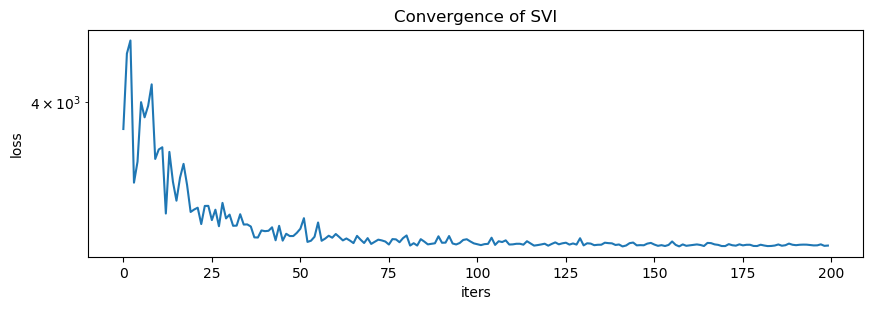

In [29]:
# Demonstrate SVI

from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

global_guide = AutoDiagonalNormal(
    poutine.block(model, expose=[
        'class_probs', 'step_probs']))

pyro.clear_param_store()
optim = pyro.optim.Adam({'lr': 0.05, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2, num_particles=3)
svi = SVI(model, global_guide, optim, loss=elbo)

losses = []
for i in range(200):
    loss = svi.step(data, n_steps)
    losses.append(loss)
    if (i % 10 == 0):
        print ".",
    if (i % 100 == 0):
        print global_guide.median()
print "Done"
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()

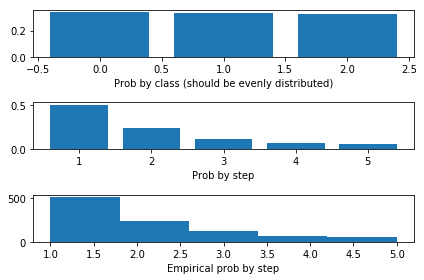

In [30]:
# real_avg_num_steps
avg_num_steps = n_steps.cpu().detach().numpy().mean(axis=-1)

plt.figure()
plt.subplot(3, 1, 1)
plt.bar(np.arange(n_classes), global_guide.median()["class_probs"].cpu().detach().numpy())
plt.xlabel("Prob by class (should be evenly distributed)")
plt.subplot(3, 1, 2)
plt.bar(np.arange(max_num_steps)+1, global_guide.median()["step_probs"].cpu().detach().numpy())
plt.xlabel("Prob by step")
plt.subplot(3, 1, 3)
plt.hist(n_steps.cpu().detach().numpy(), bins=max_num_steps)
plt.xlabel("Empirical prob by step (sanity check against plot above)")
plt.tight_layout()

In [32]:
# Demonstrate MCMC

from pyro.infer.mcmc import HMC, MCMC, NUTS
from pyro.infer import EmpiricalMarginal

hmc_kernel = HMC(model, step_size=0.0855, num_steps=4)
mcmc_run = MCMC(hmc_kernel, num_samples=400, warmup_steps=100).run(data, n_steps)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdXYXJtdXAnLCBtYXg9NTAwLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXUnaW7igKY=


tensor([0.5145, 0.2410, 0.1227, 0.0650, 0.0569])
tensor([0.3412, 0.3306, 0.3281])


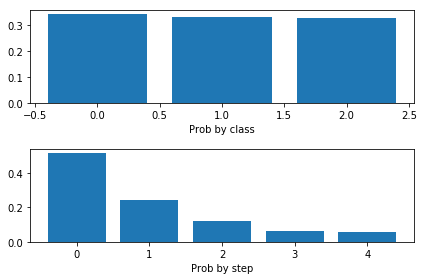

In [34]:
posterior = EmpiricalMarginal(mcmc_run, 'step_probs')
print posterior.mean 
posterior = EmpiricalMarginal(mcmc_run, 'class_probs')
print posterior.mean 

plt.figure()
plt.subplot(2, 1, 1)
plt.bar(np.arange(n_classes), EmpiricalMarginal(mcmc_run, "class_probs").mean.cpu().detach().numpy())
plt.xlabel("Prob by class")
plt.subplot(2, 1, 2)
plt.bar(np.arange(max_num_steps), EmpiricalMarginal(mcmc_run, "step_probs").mean.cpu().detach().numpy())
plt.xlabel("Prob by step")
plt.tight_layout()